In [1]:
import os
os.chdir("C:/Proyectos/sales-data-cleaning")
print("Now working in:", os.getcwd())

Now working in: C:\Proyectos\sales-data-cleaning


In [4]:
# --- Rutas robustas para Jupyter ---
from pathlib import Path
import os

# Punto de partida: donde está este notebook
BASE = Path().resolve()
# Si estamos dentro de .../notebooks, sube un nivel al root del proyecto
if BASE.name.lower() == "notebooks":
    BASE_DIR = BASE.parent
else:
    BASE_DIR = BASE

DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results"

print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR.exists(), DATA_DIR)
print("RESULTS_DIR:", RESULTS_DIR.exists(), RESULTS_DIR)

# (Opcional) forzar el directorio de trabajo al root del proyecto
os.chdir(BASE_DIR)
print("Working dir set to:", Path().resolve())

BASE_DIR: C:\Proyectos\sales-data-cleaning
DATA_DIR: True C:\Proyectos\sales-data-cleaning\data
RESULTS_DIR: True C:\Proyectos\sales-data-cleaning\results
Working dir set to: C:\Proyectos\sales-data-cleaning


In [5]:
import pandas as pd

RAW_CSV  = DATA_DIR / "raw_superstore.csv"
RAW_XLSX = DATA_DIR / "raw_superstore.xlsx"

def load_superstore():
    # 1) CSV con varias codificaciones posibles
    if RAW_CSV.exists():
        for enc in ["utf-8", "latin1", "ISO-8859-1", "cp1252"]:
            try:
                df = pd.read_csv(RAW_CSV, encoding=enc)
                print(f"Loaded CSV with encoding='{enc}':", RAW_CSV)
                return df
            except UnicodeDecodeError:
                continue
        raise UnicodeDecodeError("utf-8/latin1", b"", 0, 1, 
                                 f"Could not decode {RAW_CSV} with common encodings.")
    # 2) Excel como alternativa
    if RAW_XLSX.exists():
        df = pd.read_excel(RAW_XLSX)
        print("Loaded Excel:", RAW_XLSX)
        return df
    
    # 3) Si no existe ninguno, error claro
    raise FileNotFoundError(
        f"No raw file found.\nExpected one of:\n - {RAW_CSV}\n - {RAW_XLSX}"
    )

df = load_superstore()
print("Shape:", df.shape)
df.head()

Loaded CSV with encoding='latin1': C:\Proyectos\sales-data-cleaning\data\raw_superstore.csv
Shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
import numpy as np

df_raw = df.copy()

# 1) quitar duplicados fila exacta
dup_count = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {dup_count} exact duplicate rows.")

# 2) parseo de fechas si existen
for col in ["Order Date", "Ship Date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# 3) normalización simple de texto (ejemplos)
for col in ["State", "City", "Region", "Category", "Sub-Category", "Ship Mode"]:
    if col in df.columns:
        df[col] = (df[col].astype(str)
                            .str.strip()
                            .str.replace(r"\s+", " ", regex=True)
                            .str.title())

# 4) columnas numéricas habituales
for col in ["Sales", "Quantity", "Discount", "Profit"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 5) reporte de nulos
nulls = df.isna().sum()
print("Missing values:\n", nulls[nulls>0].sort_values(ascending=False))

df.head()

Removed 0 exact duplicate rows.
Missing values:
 Series([], dtype: int64)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [7]:
# Imputación mínima de ejemplo (ajusta según criterio)
# - Fechas: se dejan como NaT (o filtra si prefieres)
# - Numéricos: ejemplo de rellenado simple (mejor decidir por contexto real)
for col in ["Sales", "Quantity", "Discount", "Profit"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Outliers simple en 'Sales' (winsorización suave) — opcional
if "Sales" in df.columns:
    q_low, q_hi = df["Sales"].quantile([0.01, 0.99])
    df["Sales"] = df["Sales"].clip(lower=q_low, upper=q_hi)

# Guardar limpio
CLEAN = DATA_DIR / "clean_superstore.csv"
df.to_csv(CLEAN, index=False, encoding="utf-8")
print("Saved clean dataset to:", CLEAN)

Saved clean dataset to: C:\Proyectos\sales-data-cleaning\data\clean_superstore.csv


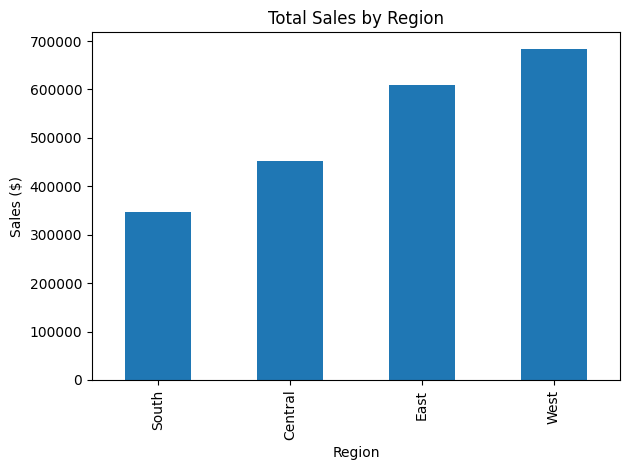

Saved: C:\Proyectos\sales-data-cleaning\results\sales_by_region.png


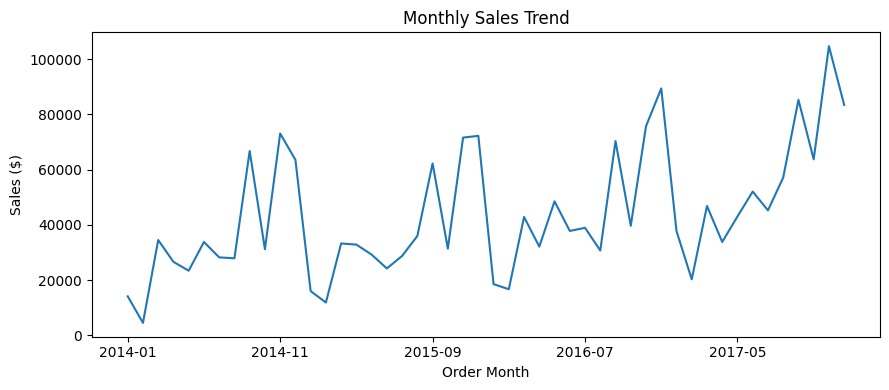

Saved: C:\Proyectos\sales-data-cleaning\results\monthly_sales_trend.png


In [8]:
import matplotlib.pyplot as plt

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# 1) ventas por región
if {"Region","Sales"}.issubset(df.columns):
    plot1 = RESULTS_DIR / "sales_by_region.png"
    (df.groupby("Region")["Sales"]
       .sum()
       .sort_values()
       .plot(kind="bar", title="Total Sales by Region"))
    plt.ylabel("Sales ($)")
    plt.tight_layout()
    plt.savefig(plot1, dpi=120)
    plt.show()
    print("Saved:", plot1)

# 2) tendencia mensual
if {"Order Date","Sales"}.issubset(df.columns):
    df["Order Month"] = df["Order Date"].dt.to_period("M").astype(str)
    plot2 = RESULTS_DIR / "monthly_sales_trend.png"
    (df.groupby("Order Month")["Sales"].sum()
       .plot(title="Monthly Sales Trend", figsize=(9,4)))
    plt.ylabel("Sales ($)")
    plt.tight_layout()
    plt.savefig(plot2, dpi=120)
    plt.show()
    print("Saved:", plot2)

In [9]:
insights = {}

if {"Region","Sales"}.issubset(df.columns):
    by_region = df.groupby("Region")["Sales"].sum().sort_values(ascending=False)
    insights["Top region by sales"] = f"{by_region.index[0]} (Sales=${by_region.iloc[0]:,.0f})"

if {"Category","Sales"}.issubset(df.columns):
    by_cat = df.groupby("Category")["Sales"].sum().sort_values(ascending=False)
    insights["Top category"] = f"{by_cat.index[0]} (Sales=${by_cat.iloc[0]:,.0f})"

if {"Order Date","Sales"}.issubset(df.columns):
    monthly = (df
               .set_index("Order Date")
               .resample("M")["Sales"]
               .sum()
               .sort_values(ascending=False))
    if len(monthly):
        best_month = monthly.index[0].strftime("%Y-%m")
        insights["Best month (by sales)"] = f"{best_month} (Sales=${monthly.iloc[0]:,.0f})"

print("Key insights:")
for k,v in insights.items():
    print(f" - {k}: {v}")

Key insights:
 - Top region by sales: West (Sales=$683,855)
 - Top category: Furniture (Sales=$724,402)
 - Best month (by sales): 2017-11 (Sales=$104,708)


C:\Users\clml\AppData\Local\Temp\ipykernel_13452\2357360562.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["Sales"]


In [10]:
report_txt = RESULTS_DIR / "summary_report.txt"

with open(report_txt, "w", encoding="utf-8") as f:
    f.write("Sales Data Cleaning and Trend Analysis — Summary\n")
    f.write("================================================\n\n")
    f.write(f"Rows after cleaning: {len(df):,}\n\n")
    if insights:
        f.write("Key insights:\n")
        for k,v in insights.items():
            f.write(f" - {k}: {v}\n")
print("Saved summary to:", report_txt)

Saved summary to: C:\Proyectos\sales-data-cleaning\results\summary_report.txt
